In [ ]:
from importlib import reload  # Python 3.4+
from numba import njit
import fibertools as ft
import pyranges as pr
import polars as pl
import pandas as pd
import mokapot
from fibertools.readutils import read_in_bed_file
from fibertools.utils import make_msp_features, join_msp_and_m6a
from fibertools.utils import n_overlaps
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
import heapq
import os 
import sys
import pickle

np.random.seed(1)

sns.set_context("talk")
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi']= 300

def disjoint_bins(start, ends, spacer_size=0):
    h = []
    min_bin = 0
    heapq.heappush(h, (0, min_bin))

    bins = []
    for st,en in zip(start, ends):
        if st > h[0][0] + spacer_size:
            _old_en, b = heapq.heappop(h)
        else:
            min_bin += 1 
            b = min_bin
        heapq.heappush(h, (en, b))
        bins.append(b)
    return bins


def disjoint_bins_opt(start, ends, spacer_size=0):
    max_bin = 0
    min_starts = [(-spacer_size, max_bin)]
    bins = []
    for st,en in zip(start, ends):
        added = False
        for idx, (min_bin_st, b) in enumerate(min_starts):
            if st >= min_bin_st + spacer_size:
                min_starts[idx] = (en, b)
                bins.append(b)
                added = True
                break
        if not added:
            max_bin += 1
            min_starts.append( (en, max_bin) )
            bins.append(max_bin)
            
    return bins

def enable_log():
    logging.basicConfig(
        level=logging.INFO,
        format="%(levelname)s: %(message)s",
    )

def disable_log():
    logging.basicConfig(
        level=logging.WARNING,
        format="%(levelname)s: %(message)s",
    )

    
@njit
def find_nearest_index_old(array, values):
    array = np.asarray(array)
    idxs = []
    for val in values:
        idxs.append( (np.abs(array - val)).argmin())
    return np.array(idxs)

def find_nearest_q_values(orig_scores, orig_q_values, new_scores):
    orig_scores=np.flip(orig_scores)
    orig_q_values=np.flip(orig_q_values)
    idxs = np.searchsorted(orig_scores, new_scores, side="left")
    idxs[idxs >= len(orig_q_values)] = len(orig_q_values)-1 
    return np.array(orig_q_values)[idxs]


def make_percolator_input(msp_features_df, dhs_df, sort=True):
    """write a input file that works with percolator.

    Args:
        msp_features_df (_type_): _description_
        out_file (_type_): _description_

    return None
    """
    # need to add:   SpecId	Label ... Peptide Proteins
    dhs_null = n_overlaps(msp_features_df, dhs_df[dhs_df.name != "DHS"])
    dhs_true = n_overlaps(msp_features_df, dhs_df[dhs_df.name == "DHS"])

    out_df = msp_features_df.copy()
    
    out_df.insert(1, "Label", 0)
    out_df.loc[dhs_true > 0, "Label"] = 1
    out_df.loc[dhs_null > 0, "Label"] = -1
    # if the msp is short make it null
    out_df.loc[ (dhs_true > 0) & (out_df.msp_len <= args.min_tp_msp_len), "Label"] = -1
        
    condition = (dhs_null > 0) | (dhs_true > 0)
    
    if "SpecId" in out_df.columns:
        out_df.drop("SpecId", axis=1, inplace=True)
    out_df.insert(0, "SpecId", out_df.index)

    to_remove = ["ct", "st", "en", "fiber"]
    out_df.drop(to_remove, axis=1, inplace=True)

    out_df["Peptide"] = out_df.SpecId
    out_df["Proteins"] = out_df.SpecId
    out_df["scannr"] = out_df.SpecId
    out_df["log_msp_len"] = np.log(out_df["msp_len"])

    out_df.sort_values(["Label"], ascending=False, inplace=True)
    return out_df

def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

In [6]:
from dataclasses import dataclass

@dataclass
class Args:
    """Class for keeping track of an item in inventory."""
    msp_bed12: str = "../tests/data/test_fiber_calls.bed.gz"
    m6a_bed12: str= "../tests/data/test_fiber_m6A_calls.bed.gz"
    genome: str="../tests/data/test.fa.gz"
    dhs: str="../tests/data/dhs_with_null.bed.gz"
    min_tp_msp_len: int = 40
    #dhs: str="../tests/data/test_dhs_with_null.bed.gz"
    bin_width: int = 40
    bin_num: int = 5
    n_rows: int = None
    verbose: bool = False
    

args = Args()
log_format = "[%(levelname)s][Time elapsed (ms) %(relativeCreated)d]: %(message)s"
log_level = logging.DEBUG if args.verbose else logging.WARNING
#logging.basicConfig(format=log_format, level=log_level)

In [7]:
df = join_msp_and_m6a(args)
AT_genome = ft.make_AT_genome(args.genome, df)

In [8]:
df["bin"] = disjoint_bins_opt(df.st, df.en, spacer_size=100)

In [ ]:
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
args.bin_num = 9
msp_feat_9 = make_msp_features(args, df, AT_genome)

In [ ]:
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARNING)
dhs = read_in_bed_file(args.dhs, n_rows=args.n_rows)
dhs = dhs[dhs.ct == "chr11"]

In [ ]:
pin = make_percolator_input(msp_feat_9, dhs)

In [ ]:
if False :
    with open("indata.dat", "wb") as f:
        pickle.dump(df, f)
        pickle.dump(dhs, f)
        pickle.dump(pin, f)


In [ ]:
df, dhs, pin = list(loadall("indata.dat"))

In [133]:
must_drop = ['qValue','strand', 'tst', 'ten', 'color']
for col in must_drop:
    if col in pin.columns:
        pin.drop(col, axis=1, inplace=True)

train = pin[(pin.Label!=0) ].copy()#.sample(10_000) # & (pin.msp_len > 1)

In [136]:
min_size = 1
train_psms = mokapot.read_pin(train[train.msp_len >= min_size])
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)
grid = {
    "n_estimators": [25, 50, 100],
    "scale_pos_weight": [scale_pos_weight], #[0.5, 1, 2], #np.logspace(0, 2, 3),
    "max_depth": [3,6,9],
    "min_child_weight": [3, 6, 9],
    "gamma": [0.1, 1, 10],
}
xgb_mod = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="auc"),
    param_grid=grid,
    cv=3,
    scoring="roc_auc",
    verbose=2,
)
mod = mokapot.Model(xgb_mod, train_fdr=0.1, subset_max_train=200_000) # override=True

In [137]:
moka_conf, models = mokapot.brew(train_psms, mod, test_fdr=0.05)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.6075021712807704; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.6075021712807704; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.6075021712807704; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.6075021712807704; total time=   2.2s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.6075021712807704; total time=   2.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.6075021712807704; total time=   2.2s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=150, scale_pos_weight=1.6075021712807704; total time=   3.3s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3

In [2]:

sys.setrecursionlimit(1_000)
z=pickle.load(open("model.dat","rb"))

NameError: name 'sys' is not defined

In [261]:
for x in loaded:
    print(x)

RecursionError: maximum recursion depth exceeded

In [241]:
models[2].estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=10, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=12, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.6075021712807704,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

205655.0

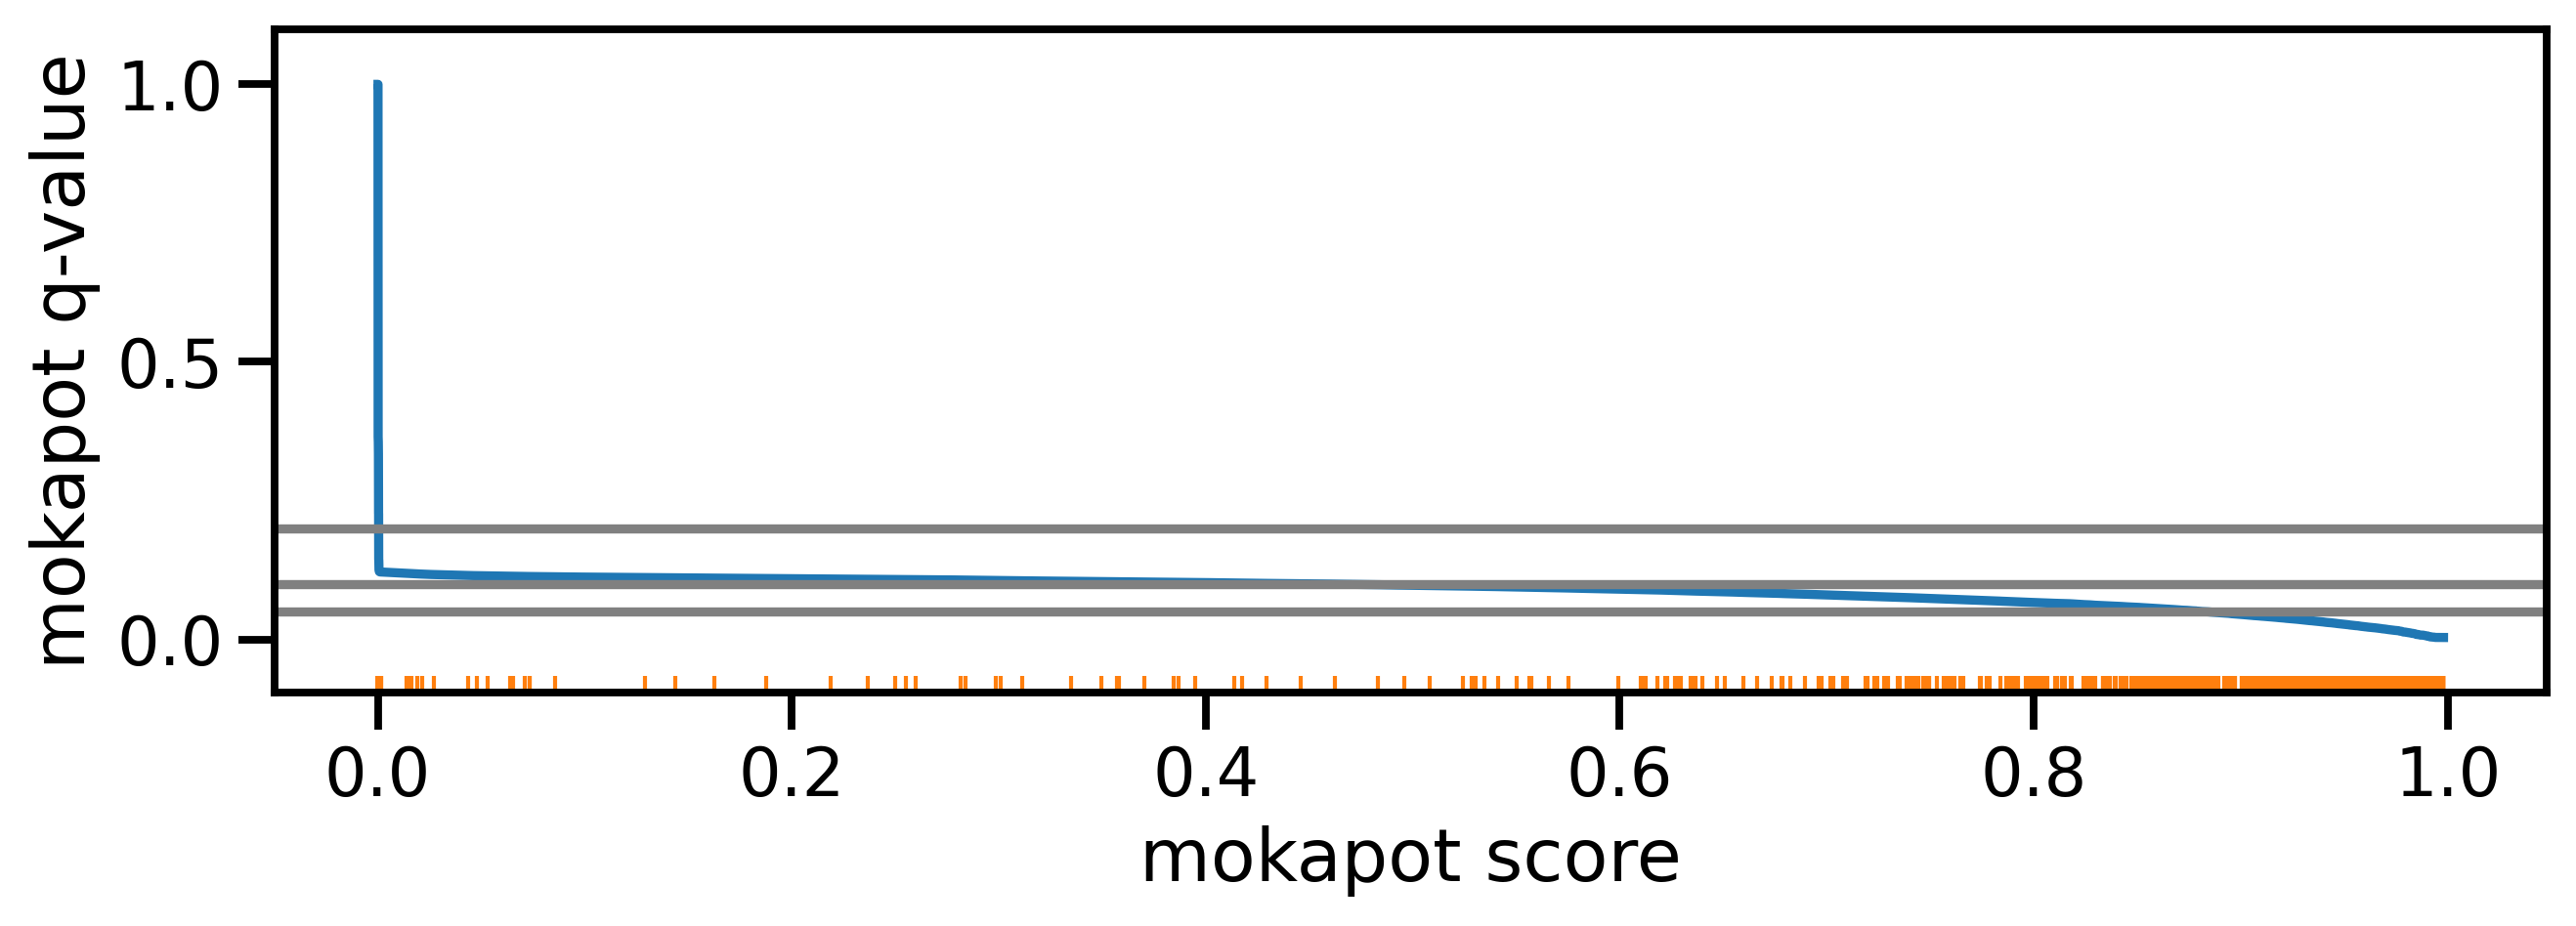

In [141]:
graph = sns.lineplot(data=moka_conf.psms.sample(5000), x="mokapot score", y ="mokapot q-value")
graph.axhline(0.05, color="gray")
graph.axhline(0.10, color="gray")
graph.axhline(0.20, color="gray")
#sns.scatterplot(data=moka_conf.psms, x="mokapot score", y ="mokapot q-value", size=0.01)
sns.rugplot(data=moka_conf.psms.sample(5000), x="mokapot score")
train.shape[0]/2

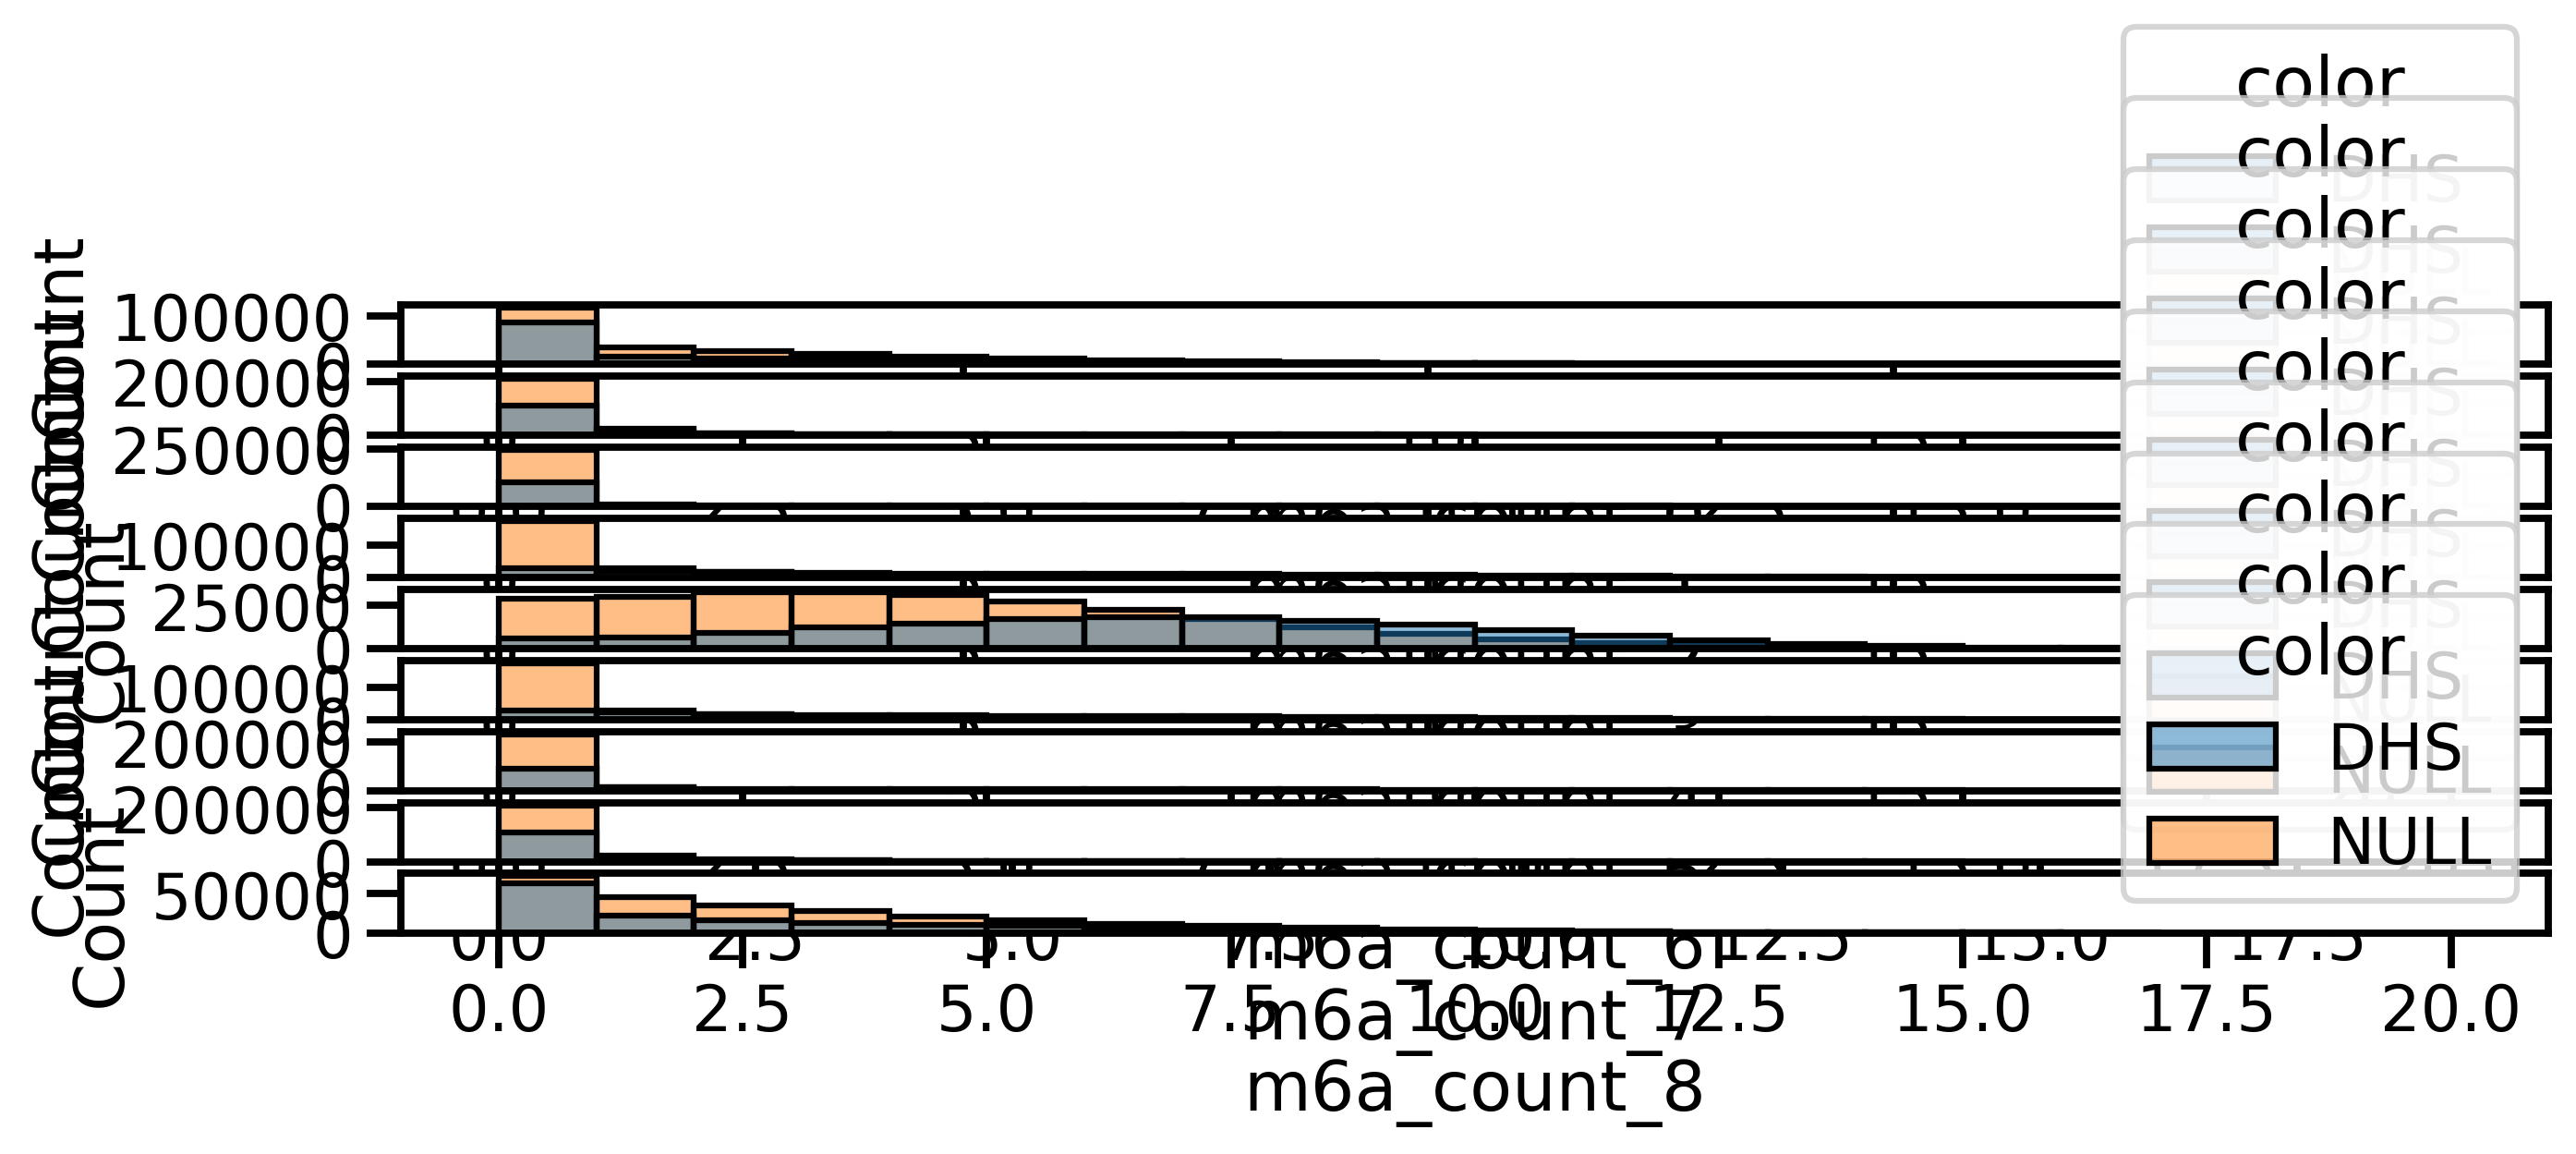

In [142]:
n=args.bin_num
p, ax = plt.subplots(n,1)
train["color"] = "NULL"
train.loc[train.Label == 1, "color"] = "DHS"
for i in range(n):
    sns.histplot(data=train, x=f"m6a_count_{i}", hue="color", bins=20, ax = ax[i])

In [161]:
test_psms = mokapot.read_pin(pin)
all_scores = [model.predict(test_psms) for model in models]

(15853030, 43)

In [163]:
scores = np.mean(np.array(all_scores), axis=0)
#scores = np.amin(np.array(all_scores), axis=0)
#scores = np.amax(np.array(all_scores), axis=0)

q_values = find_nearest_q_values(
    moka_conf.psms["mokapot score"],
    moka_conf.psms["mokapot q-value"],
    scores
)
merged = pin.copy()
merged["mokapot score"] = scores
merged["mokapot q-value"] = q_values
merged.shape

(15853030, 43)

In [164]:
FDR = 0.10
out_col = f"Predicted accessible, FDR < {FDR}"
merged[out_col] = merged["mokapot q-value"] < FDR
#merged.groupby(out_col).describe(include = "all").transpose().loc[["m6a_frac", "msp_len"]]
merged[out_col].value_counts()

False    15518331
True       334699
Name: Predicted accessible, FDR < 0.1, dtype: int64

<AxesSubplot:xlabel='m6a_frac', ylabel='msp_len'>

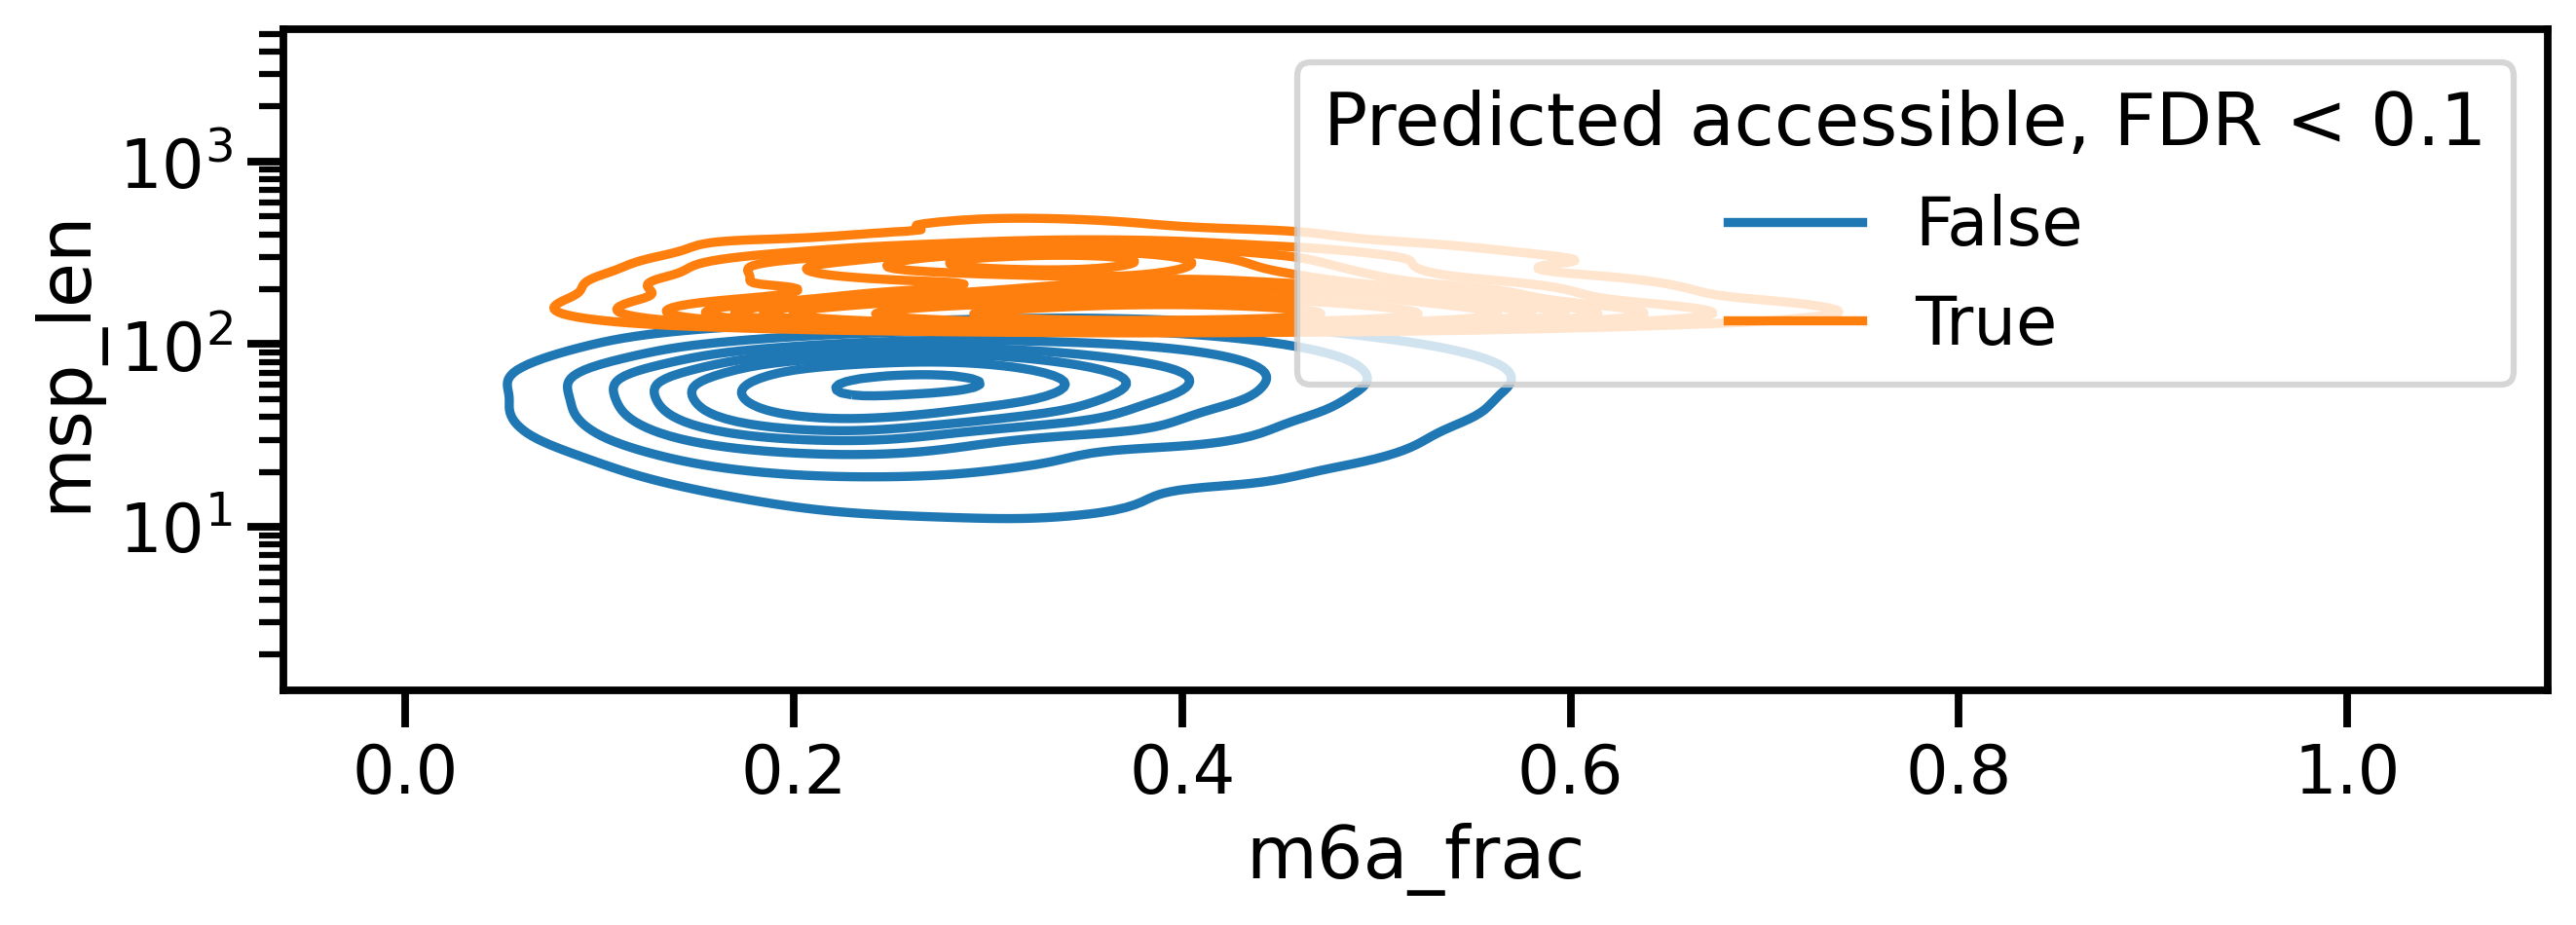

In [165]:
sample_n = 10_000
tmp = (merged
       .query("msp_len > 1")
       .groupby(out_col)
       .apply(lambda x: x.sample(sample_n))
)

sns.kdeplot(
    data=tmp,
    y="msp_len",
    x="m6a_frac",
    hue=out_col,
    #hue = "mokapot q-value",
    thresh=.1,
    log_scale=[False, True]
)

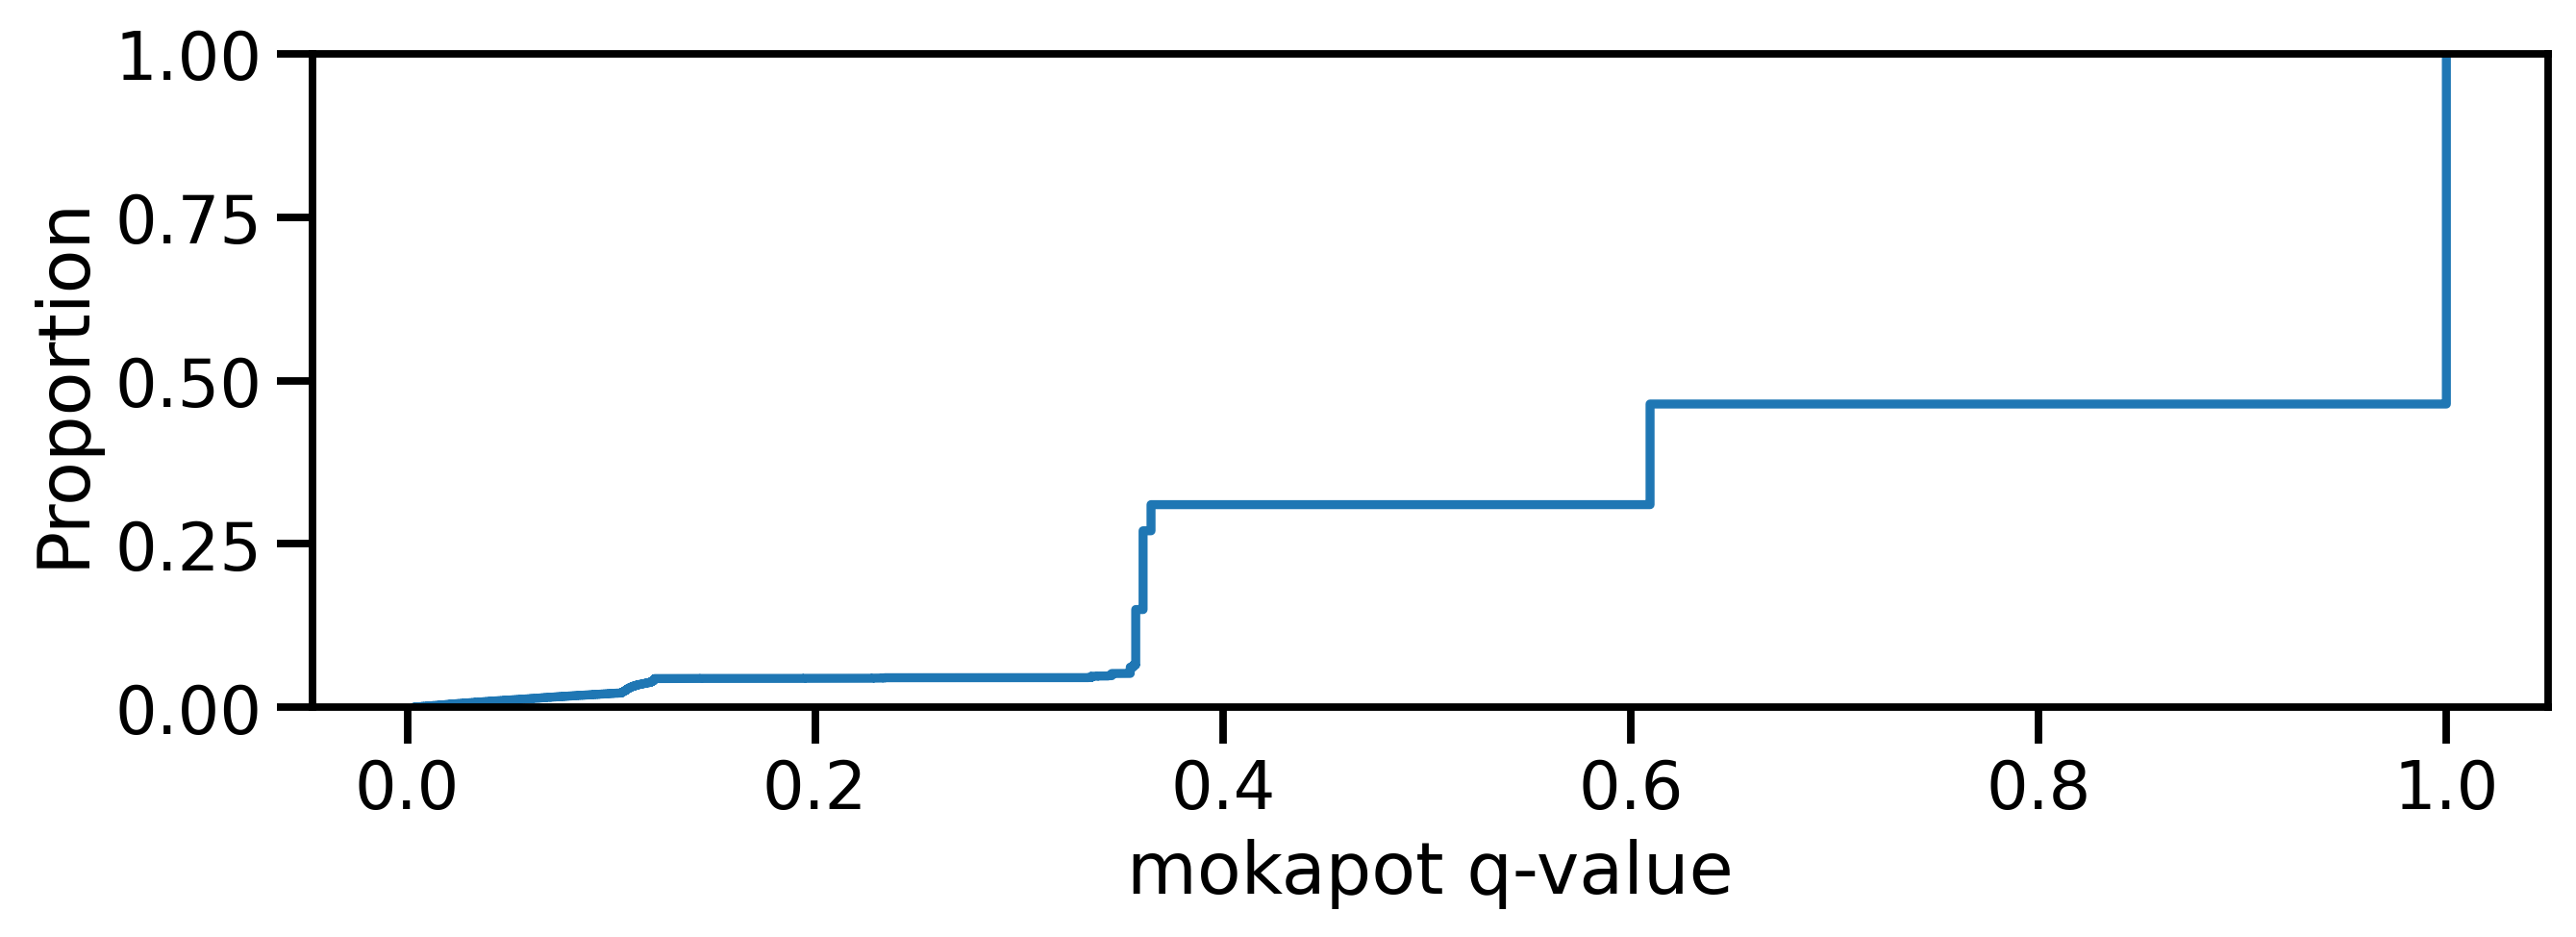

In [166]:
merged["x"]=merged["mokapot q-value"].rank()

fig, ax = plt.subplots()
sns.ecdfplot(
    data = merged, #merged[merged["mokapot q-value"] < 0.1],
    x="mokapot q-value",
    ax=ax
)
max_x = 1
max_y = (merged["mokapot q-value"] < max_x).sum()/merged.shape[0]
#ax.set_xlim(0, max_x)
#ax.set_ylim(0, max_y*1.01)
plt.show()


<AxesSubplot:xlabel='m6a_frac', ylabel='msp_len'>

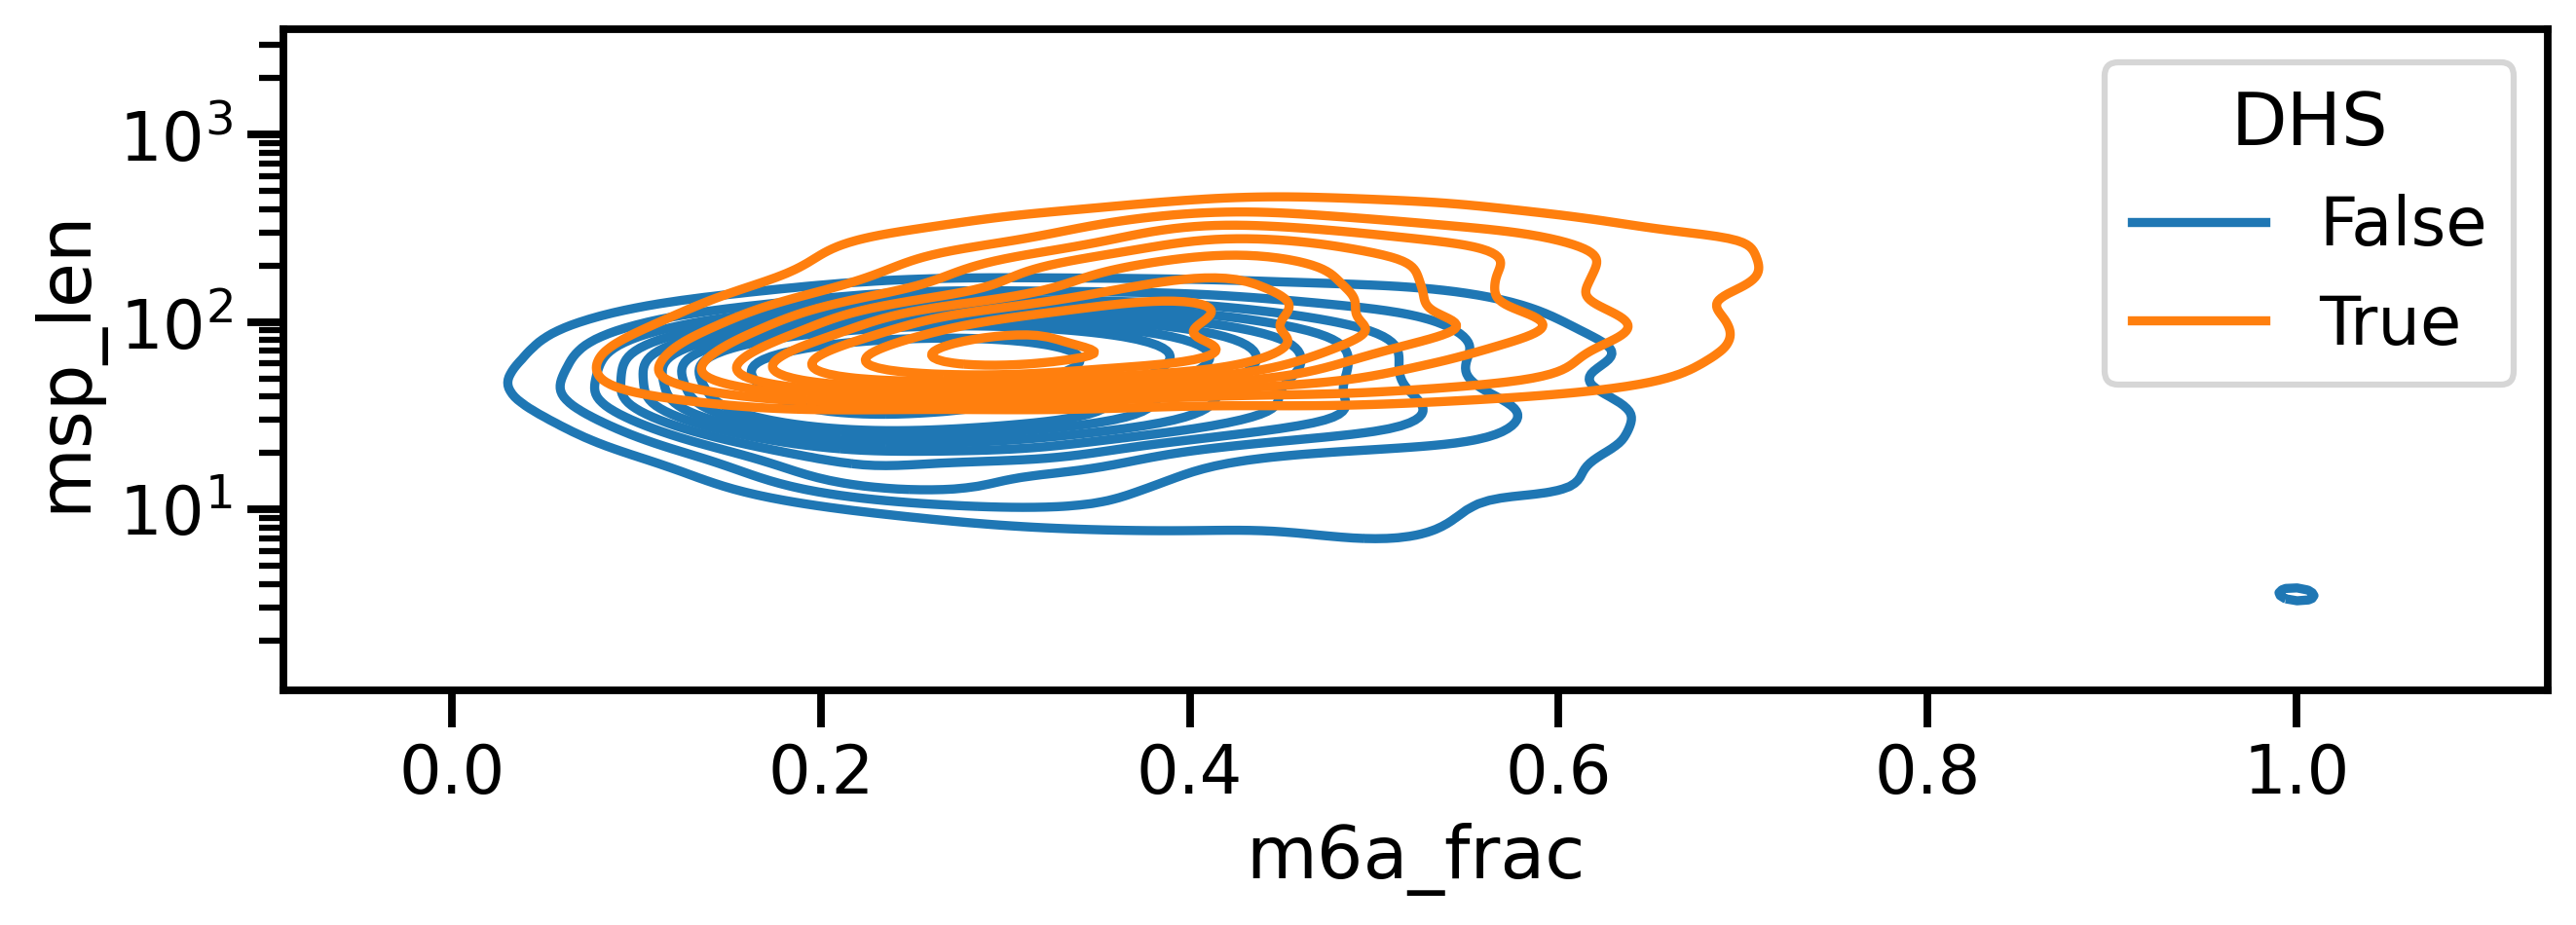

In [148]:
tmp = pin.loc[pin.Label != 0].sample(sample_n).copy()
tmp["DHS"] = tmp.Label > 0
sns.kdeplot(
    data=tmp.query("msp_len > 1"),
    y="msp_len",
    x="m6a_frac",
    hue="DHS",
    thresh=.1,
    log_scale=[False, True]
)

In [167]:
merged.head()
out.shape, merged.shape
out["SpecId"] = out.index

In [230]:
out["qValue"] = 1
out["strand"] = "+"
out.loc[merged.SpecId,"qValue"] = merged["mokapot q-value"]
out["tst"] = out["st"]
out["ten"] = out["en"]
out["color"] = "147,112,219"
#out.loc[ out.qValue < 0.5, "color"] =  "255,255,0"
#out.loc[ out.qValue < 0.4, "color"] =  "255,255,0"
out.loc[ out.qValue < 0.3, "color"] =  "255,255,0"
out.loc[ out.qValue < 0.2, "color"] =  "255,140,0"
out.loc[ out.qValue < 0.1, "color"] =  "255,0,0"
out.loc[ out.qValue < 0.05, "color"] =  "139,0,0"
out = out.merge(rows[["fiber", "bin"]])

In [231]:
rows = pd.DataFrame(df.to_dicts()).copy()

rows["spacer_st"] = rows.apply(lambda row: (row["bst_msp"]+row["bsize_msp"])[:-1] + row["st"], axis=1)
rows["spacer_en"] = rows.apply(lambda row: row["bst_msp"][1:] + row["st"] + 1, axis=1)
z = rows.explode(["spacer_st","spacer_en"])
z["qValue"] = 1
z["strand"] = "+"
z["tst"] = z["spacer_st"]
z["ten"] = z["spacer_st"] # make non msp thin blocks
z["color"] = "230,230,230"
z.drop(columns=['st', 'en'], inplace=True)
z.rename(columns={"spacer_st":"st", "spacer_en":"en"}, inplace=True)

In [232]:
outcols = ['ct', 'st', 'en', 'fiber', 'score', "strand", "tst", "ten", "color", 'qValue', 'bin']
final_out = (pd.concat([
        out[outcols],
        z[outcols]
    ])
 .sort_values(["ct", "st", "en"])
 .rename(columns={"ct":"#ct"})
)
final_out["score"] = (final_out.qValue*100).astype(int)

In [234]:
final_out.to_csv("/Users/mrvollger/Desktop/tmp.tbl.gz", 
         sep="\t",
         index=False, 
         compression="gzip"
        )

In [237]:
ODIR="/Users/mrvollger/Desktop/repos/fibertools/tmp"
os.makedirs(f"{ODIR}/", exist_ok=True)

for cur_bin in sorted(final_out.bin.unique()):
    sys.stderr.write(f"\r{cur_bin}")
    (final_out
         .loc[final_out.bin == cur_bin]
         .to_csv(f"{ODIR}/bin.{cur_bin}.bed.gz", 
                 sep="\t",
                 index=False, 
                 compression="gzip"
                )
    )

133

In [ ]:
final_out.shape, out.shape, z.shape
final_out.bin.describe()